In [1]:
import os
import scipy.io as sio
import scipy.misc as smisc
import numpy as np
import re as regexp
import math
import matplotlib.pyplot as plt
import scipy

from scipy import ndimage as ndi
import matplotlib.pyplot as plt
from skimage.feature import peak_local_max
from skimage import data, img_as_float

import scipy.io
import time
import glob,os
import cv2
from scipy import optimize
from pylab import *

import imutils
import cv2

# Goal of this script is to test whether 4DSTEM data collected on DE camera can quantitatively match to simulation

## Process simulation results from Prismatic

In [2]:
# 2D output, collection angle ranges from 112.9 mrad to 353.33 mrad
path = '/srv/home/chenyu/antisite/STO_CL60/CL60_8x8model/20FP/'
nslice = 25
source_size = 90
integration_radius = 120
px_size = 17.5

intensity = np.zeros(nslice)

for islice in range(nslice):
    
    name = '_slice' + str(islice) + '_'
    file_2D = [image for image in os.listdir(path) if '2Doutput' and name in image]
    file_2D = file_2D[0]
#     print(file_2D)
    image_2D = loadMRCfile(path + file_2D)

#     im = img_as_float(Convolution_2D(image,source_size))
    im = img_as_float(image_2D)

    # image_max is the dilation of im with a 5x5 structuring element
    # It is used within peak_local_max function
    image_max = ndi.maximum_filter(im, size=5, mode='constant')

    # Comparison between image_max and im to find the coordinates of local maxima
    # min_distance = 20 will find only the Sr peak at center
    # Peak positions are found in integers
    coordinates = peak_local_max(im, min_distance=20)
#     print(coordinates)
    
    center = [coordinates[0,0], coordinates[0,1]]
    circular_mask = create_circular_mask(im.shape[0],im.shape[1],center, integration_radius/px_size)
    
    # Intensity is a list of averaged intensity inside the Sr mask
    intensity[islice] = (im*circular_mask).sum()/circular_mask.sum()
    
# Display results
fig, axes = plt.subplots(1, 3, figsize=(8, 3), sharex=True, sharey=True)
ax = axes.ravel()
ax[0].imshow(im, cmap=plt.cm.gray)
ax[0].axis('off')
ax[0].set_title('Original')

ax[1].imshow(image_max, cmap=plt.cm.gray)
ax[1].axis('off')
ax[1].set_title('Maximum filter')

im2 = ax[2].imshow(im, cmap=plt.cm.gray)
ax[2].autoscale(False)
ax[2].plot(coordinates[:, 1], coordinates[:, 0], 'r.')
ax[2].axis('off')
ax[2].set_title('Peak local max')
fig.colorbar(im2,ax=ax[2])

fig.tight_layout()

plt.show()
print(intensity)

NameError: name 'loadMRCfile' is not defined

### Use intensity simulated by autostem - Multislice

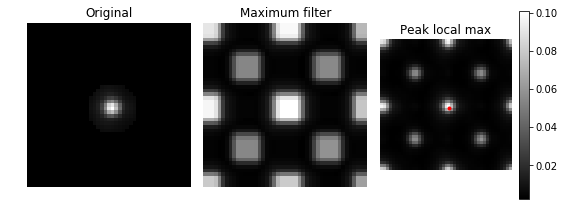

[0.00036292 0.00085735 0.00144585 0.0021531  0.00287455 0.00372524
 0.0046215  0.00549865 0.00640501 0.00721954 0.00796388 0.0086874
 0.00938996 0.01008441 0.01078178 0.01142657 0.01203881 0.0126435
 0.01319362 0.01371174 0.0141628  0.01461575 0.01505456 0.01548433
 0.01588757]


In [19]:
path = '/srv/home/chenyu/multislice/STO/STO_8x8uc_CL60_HAADF_20FP_1ucIncrement.mat'

nslice = 25
source_size = 90
integration_radius = 120
px_size = 17.5
file_2D = sio.loadmat(path)
file_2D = file_2D['HAADF']

intensity = np.zeros(nslice)

for islice in range(nslice):
    
    image_2D = file_2D[:,:,islice]

#     im = img_as_float(Convolution_2D(image,source_size))
    im = img_as_float(image_2D)

    # image_max is the dilation of im with a 5x5 structuring element
    # It is used within peak_local_max function
    image_max = ndi.maximum_filter(im, size=5, mode='constant')

    # Comparison between image_max and im to find the coordinates of local maxima
    # min_distance = 20 will find only the Sr peak at center
    # Peak positions are found in integers
    coordinates = peak_local_max(im, min_distance=20)
#     print(coordinates)
    
    center = [coordinates[0,0], coordinates[0,1]]
    circular_mask = create_circular_mask(im.shape[0],im.shape[1],center, integration_radius/px_size)
    
    # Intensity is a list of averaged intensity inside the Sr mask
    intensity[islice] = (im*circular_mask).sum()/circular_mask.sum()
    
# Display results
fig, axes = plt.subplots(1, 3, figsize=(8, 3), sharex=True, sharey=True)
ax = axes.ravel()
ax[0].imshow(im*circular_mask, cmap=plt.cm.gray)
ax[0].axis('off')
ax[0].set_title('Original')

ax[1].imshow(image_max, cmap=plt.cm.gray)
ax[1].axis('off')
ax[1].set_title('Maximum filter')

im2 = ax[2].imshow(im, cmap=plt.cm.gray)
ax[2].autoscale(False)
ax[2].plot(coordinates[:, 1], coordinates[:, 0], 'r.')
ax[2].axis('off')
ax[2].set_title('Peak local max')
fig.colorbar(im2,ax=ax[2])

fig.tight_layout()

plt.show()

print(intensity)

### Test thickness estimation using different colletion angles from the 3D output, consider detector non-uniformity 

Load detector scan map and generate response profile for different annular range

In [184]:
from scipy.interpolate import interp1d

DetectorFile = '/srv/home/chenyu/DEbackup/012119/LinearityTest_C41.093_B39.584_4Vrange/SS9_APT70/HAADF_Preview_512_512_2_20_41_PM.csv'
center = [257,261]

file=csv.reader(open(DetectorFile,'r'))
n=[]
for row in file:
    n.append(row)
            
HAADFarray = np.transpose(np.asarray(n))
HAADFarray = np.squeeze(HAADFarray)
HAADFarray = HAADFarray.astype(np.float)
DetectorScan = np.reshape(HAADFarray,(512,512))

DetectorPolar = convert(DetectorScan, [512,512], center)
(BeamLevel, DarkLevel) = BeamLevelCalibrate('/srv/home/chenyu/DEbackup/012119/LinearityTest_C41.093_B39.584_4Vrange/SS9_APT70/HAADF_Preview_512_512_2_20_41_PM.csv')
DetectorPolar = (DetectorPolar - DarkLevel)/(BeamLevel - DarkLevel)
lineprofile = np.average(DetectorPolar,axis=1)

# Each pixel in detector scan is calibrated to be 2.47 mrad

angle = np.linspace(0,(lineprofile.shape[0]-1)*2.74, num = lineprofile.shape[0])
f = interp1d(angle,lineprofile)

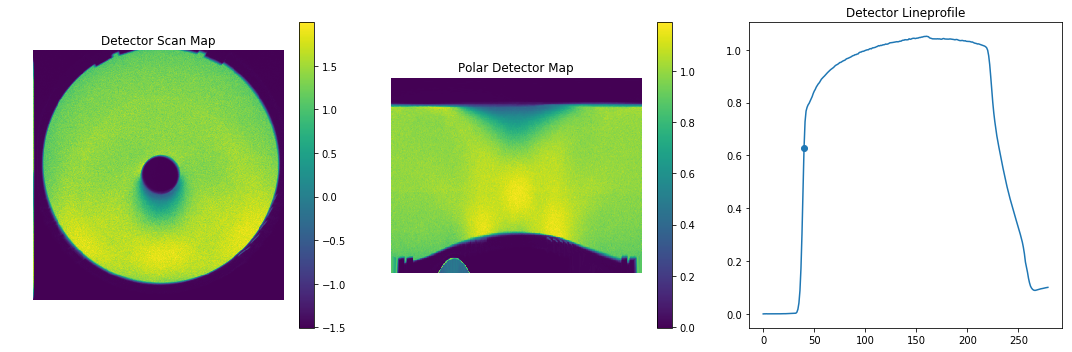

In [152]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
ax = axes.ravel()
im0 = ax[0].imshow(DetectorScan)
ax[0].axis('off')
ax[0].set_title('Detector Scan Map')
fig.colorbar(im0,ax=ax[0])

im1 = ax[1].imshow(DetectorPolar)
ax[1].axis('off')
ax[1].set_title('Polar Detector Map')
fig.colorbar(im1,ax=ax[1])

ax[2].plot(lineprofile)
ax[2].autoscale(False)
ax[2].set_title('Detector Lineprofile')
ax[2].scatter(40,lineprofile[40])

fig.tight_layout()

plt.show()

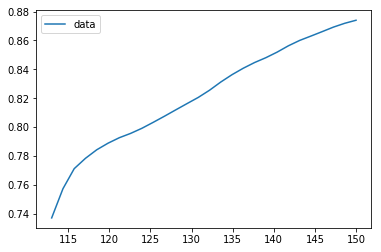

In [197]:
xnew = np.linspace(113, 150, num=28, endpoint=True)
plt.plot( xnew, f(xnew), '-')
plt.legend(['data', 'linear'], loc='best')
plt.show()

In [17]:
# 2D output, collection angle ranges from 112.9 mrad to 353.33 mrad
path = '/srv/home/chenyu/antisite/STO_CL60/ConvergenceTest_015/'
nslice = 25
source_size = 90
integration_radius = 120
px_size = 17.5
inner_angle = 113
outer_angle = 353

intensity = np.zeros(nslice+1)

for islice in range(nslice):
    
    name = 'slice' + str(islice) + '_'
    file_3D = [image for image in os.listdir(path) if 'P0001' and name in image and '2D' not in image]
    file_3D = file_3D[0]
    cube = loadMRCfile_3D(path + file_3D)
    
    # Module each layer in the simulation cube with the corresponding sensitivity in detector scan map
#     for angle in  range(cube.shape[1]):
#         cube[:,angle,:] = cube[:,angle,:]*f(angle)
        
    image = np.sum(cube[:,inner_angle-1:outer_angle,:],axis=1)

#     im = img_as_float(Convolution_2D(image,source_size))
    im = img_as_float(image)
    image_max = ndi.maximum_filter(im, size=5, mode='constant')
    coordinates = peak_local_max(im, min_distance=20)
    
    center = [coordinates[0,0], coordinates[0,1]]
    circular_mask = create_circular_mask(im.shape[0],im.shape[1],center, integration_radius/px_size)

    intensity[islice] = (im*circular_mask).sum()/circular_mask.sum()
    
# Display results
fig, axes = plt.subplots(1, 3, figsize=(8, 3), sharex=True, sharey=True)
ax = axes.ravel()
ax[0].imshow(im, cmap=plt.cm.gray)
ax[0].axis('off')
ax[0].set_title('Original')

ax[1].imshow(image_max, cmap=plt.cm.gray)
ax[1].axis('off')
ax[1].set_title('Maximum filter')

im2 = ax[2].imshow(im, cmap=plt.cm.gray)
ax[2].autoscale(False)
ax[2].plot(coordinates[:, 1], coordinates[:, 0], 'r.')
ax[2].axis('off')
ax[2].set_title('Peak local max')
fig.colorbar(im2,ax=ax[2])

fig.tight_layout()

plt.show()

print(intensity)

IndexError: list index out of range

## Process experiment HAADF images to get local thickness

### Locate all Sr peaks

0.7887370362569966 -1.12454603717154


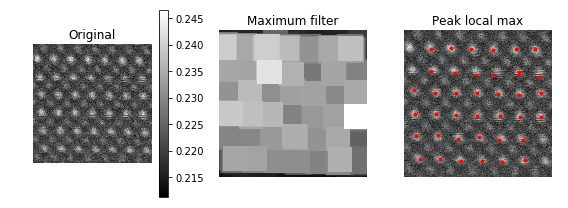

In [25]:
import csv

path = '/srv/home/chenyu/DEbackup/010619/'
sub_folders = [5]
for ifolder in range(len(sub_folders)):
    
    name = 'S' + str(sub_folders[ifolder]) + '/'
    file_HAADF = [image for image in os.listdir(path+name) if '_Preview' in image]
    file_HAADF = file_HAADF[0]
    with open(path + name + file_HAADF) as csvfile:
        file=csv.reader(open(path+name+file_HAADF,'r'))
        n=[]
        for row in file:
            n.append(row)
            
    HAADFarray = np.transpose(np.asarray(n))
    HAADFarray = np.squeeze(HAADFarray)
    HAADFarray = HAADFarray.astype(np.float)
    HAADFarray = np.reshape(HAADFarray,(150,150))
    
    (BeamLevel, DarkLevel_0) = BeamLevelCalibrate('/srv/home/chenyu/DEbackup/012119/LinearityTest_C41.093_B39.584_4Vrange/SS9_APT70/HAADF_Preview_512_512_2_20_41_PM.csv',512)
    (BeamLevel, DarkLevel) = BeamLevelCalibrate('/srv/home/chenyu/DEbackup/022119/DetectorScan/HAADF_Preview_1000_1000_5_25_30_PM.csv',1000)
    (BeamLevel, DarkLevel) = BeamLevelCalibrate('/srv/home/chenyu/DEbackup/010319/DetectorScan/HAADF_Preview_1000_1000_4_08_00_PM.csv',1000)
    print(BeamLevel,DarkLevel)
#     DarkLevel = -1.505
#     BeamLevel = 0.6759
#     DarkLevel = -1.0867
    HAADFarray = (HAADFarray - DarkLevel_0)/(BeamLevel - DarkLevel)
    
    im = img_as_float(np.reshape(HAADFarray,(150,150)))
#     im = im - np.amin(im)
    image_max = ndi.maximum_filter(im, size=25, mode='constant')

    coordinates = peak_local_max(im, min_distance=10)
    
    center = [coordinates[0,0], coordinates[0,1]]
    
fig, axes = plt.subplots(1, 3, figsize=(8, 3), sharex=True, sharey=True)
ax = axes.ravel()
im0 = ax[0].imshow(im, cmap=plt.cm.gray)
fig.colorbar(im0,ax=ax[0])
ax[0].axis('off')
ax[0].set_title('Original')

ax[1].imshow(image_max, cmap=plt.cm.gray)
ax[1].axis('off')
ax[1].set_title('Maximum filter')

ax[2].imshow(im, cmap=plt.cm.gray)
ax[2].autoscale(False)
ax[2].plot(coordinates[:, 1], coordinates[:, 0], 'r.')
ax[2].axis('off')
ax[2].set_title('Peak local max')

fig.tight_layout()

plt.show()

In [485]:
np.amin(im)
print(path,np.amin(im))

/srv/home/chenyu/DEbackup/022119/ 0.0010955870154401662


<font color='red'>Seems some pixels will have negative intensity, may need a better calibration for dark level.

### Refine each peak position using 2D Gaussian fit

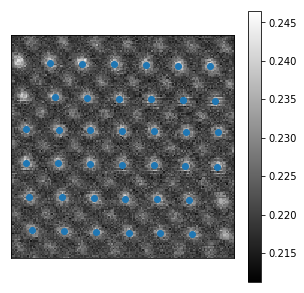

In [26]:
peaks_x_fit = []
peaks_y_fit = []
for i in range(coordinates.shape[0]):
    
    x = int(coordinates[i][1])
    y = int(coordinates[i][0])
    
    patch = im[y-7:y+7,x-7:x+7]
    bg = 0
    guess = (bg,patch[7,7]-bg,7, 7, 3, 3)
    bounds = ([0,0,0,0,1,1],[np.inf,np.inf,14,14,10,10])
    param = fitGaussianx2(patch, guess, bounds)
    
    peaks_x_fit.append(param[2]+x-7)
    peaks_y_fit.append(param[3]+y-7)

fig = plt.figure(figsize=(5,5))
im0 = plt.imshow(im,cmap=plt.cm.gray)
fig.colorbar(im0)
plt.scatter(peaks_x_fit,peaks_y_fit)
plt.xticks([])
plt.yticks([])

peaks_x_fit = np.asarray(peaks_x_fit)
peaks_y_fit = np.asarray(peaks_y_fit)
np.save(path + name + 'SrPeaks_x.npy',np.asarray(peaks_x_fit))
np.save(path + name + 'SrPeaks_y.npy',np.asarray(peaks_y_fit))

### Calculate thickness for each column

In [27]:
thickness_list = np.zeros(peaks_x_fit.shape[0])
intensity_list = np.zeros(peaks_x_fit.shape[0])
for i in range(peaks_x_fit.shape[0]):
    center = [peaks_x_fit[i],peaks_y_fit[i]]
    circular_mask = create_circular_mask(im.shape[0],im.shape[1],center, integration_radius/px_size)
    intensity_list[i] = (im*circular_mask).sum()/circular_mask.sum()  # Checked position of mask, right on atom
    thickness_list[i] = argmin(np.absolute(intensity - intensity_list[i]))+1 # have 1 uc offset, intensity[0] corresponds to 1 uc
    
# np.save(path + name + 'SrPeaks_thickness.npy',np.asarray(thickness_list))

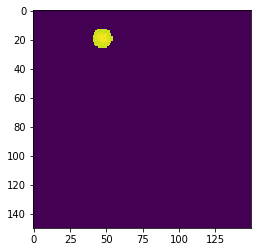

In [28]:
plt.imshow(im*circular_mask)

[25. 25. 25. 25. 25. 25. 25. 25. 25. 25. 25. 25. 25. 25. 25. 25. 25. 25.
 25. 25. 25. 25. 25. 25. 25. 25. 25. 25. 25. 25. 25. 25. 25. 25. 25. 25.
 25. 25. 25.]


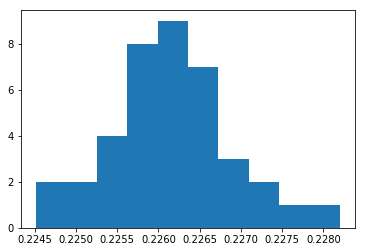

In [29]:
plt.hist(intensity_list)
print(thickness_list)

In [490]:
print(thickness_list)
print(thickness_list.mean())
print(integration_radius,px_size)
np.save(path + name + 'SrPeaks_thickness.npy',np.asarray(thickness_list))

[ 8.  8.  8.  9.  8.  8.  9.  9.  8.  9.  9.  7.  9.  9.  9.  8.  9.  8.
 10.  9.  8.  9.  8.  9.  7. 10.  9.  9.  9.  8.  9.]
8.580645161290322
120 17.5


Calibration on 010619/S7 shows inner collection angle should be around 140mrad, and this value is confirmed using 010619/S5. Change outer collection angle won't matter much, as inner collection angle is close to FOLZ, where most intensity comes from. Take this value for now.

## Compare between simulation PACBED and experiment PACBED

### Calculate beam level in experiment

In [3]:
RefPath = '/srv/home/chenyu/DEbackup/022119/C1/'
RefName = 'S0'
BeamLevel = 0
rx = 150
ry = 150
AccumulatedFrame = np.zeros((512,512))
for ix in range(rx):
    for iy in range(ry):
        filenum = ix*rx+iy+1
        frame = np.load(RefPath+'npy/'+RefName+'_'+format(filenum,'05')+'.npy')
        BeamLevel = BeamLevel + np.sum(frame)
        AccumulatedFrame = AccumulatedFrame + frame
AccumulatedFrame = AccumulatedFrame / rx / ry
BeamLevel = BeamLevel / rx / ry
mask = np.heaviside(AccumulatedFrame-10,1)
MeanBeamLevel = (mask*AccumulatedFrame).sum()/np.count_nonzero(mask)
print(BeamLevel)
print(MeanBeamLevel)

14905786.219208037
164.82769077830847


### Calculate a correction mask (norm_mask) from blank scan to correct intensity within zero disk
New gain reference was used to remove the detector stripes artifact.

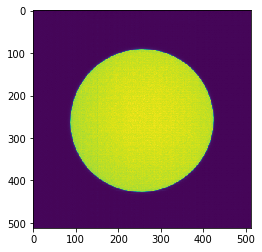

In [5]:
plt.imshow(temp)

1.1702152018052456


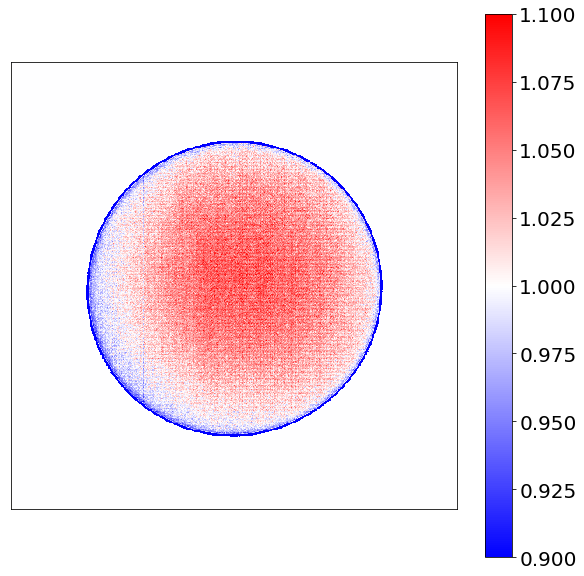

In [37]:
temp = (AccumulatedFrame + 13.93)/(1.38e7)
print((temp*mask).sum())
norm_mask = AccumulatedFrame/164*mask
norm_mask[norm_mask==0]=1
np.save('/srv/home/chenyu/DEbackup/022119/norm_mask.npy',norm_mask)
fig, ax = subplots(1,1,figsize=(10, 10))
im = ax.imshow(norm_mask,clim=[0.9,1.1],cmap=plt.get_cmap('bwr'))
cbar = fig.colorbar(im,ax=ax)
ax.set_xticks([])
ax.set_yticks([])
cbar.ax.tick_params(labelsize=20) 



[9.91853031e-01 9.34188690e-02 2.68014057e+02 2.50444780e+02
 6.50774863e+01 6.78650710e+01]


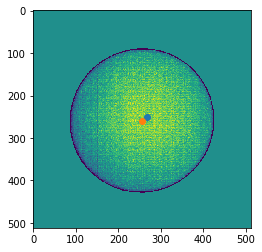

In [63]:
# Try to fit the mask to a 2D Gaussian function
# bounds and guess for background, height, cx, cy, wx, wy
guess = (1,norm_mask[256,256]-1,256,256, 3, 3)
bounds = ([0,0,200,200,1,1],[np.inf,np.inf,300,300,200,200])
param = fitGaussianx2(norm_mask, guess, bounds)
print(param)
plt.imshow(norm_mask,clim=[0.9,1.1])
plt.scatter(param[2],param[3])
plt.scatter(255,260)

In [344]:
np.save(RefPath + 'BeamLevel.npy',BeamLevel)

In [533]:
RefPath = '/srv/home/chenyu/DEbackup/022119/C1/'
BeamLevel = np.load(RefPath + 'BeamLevel.npy')
print(BeamLevel)

14910965.905783972


### Load exp and sim PACBED for certain column

In [86]:
PACBED_exp.sum()

0.9126916478034558

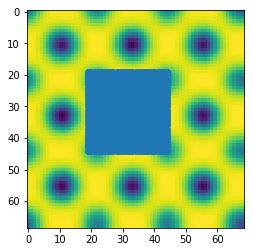

In [75]:
plt.imshow(np.sum(np.sum(sim_cube,axis=2),axis=2))
plt.scatter(col_list,row_list)

In [13]:
# Compare simulated PACBED from a unit cell to experiment PACBED
simpath = '/srv/home/chenyu/antisite/PRISMATIC/Depth0_OriginalPxSize/'
# simpath = '/srv/home/chenyu/antisite/PRISMATIC_newconv/Depth0/'
BeamLevel = np.load('/srv/home/chenyu/DEbackup/022119/BeamLevel.npy')
PACBED_exp = np.load('/srv/home/chenyu/DEbackup/022119/S5/PACBED.npy')
PACBED_exp = PACBED_exp / 150 / 150

PACBED_exp = PACBED_exp*mask/norm_mask + PACBED_exp*(1-mask)
# PACBED_exp_2 = (PACBED_exp+13.93)/(1.38e7)/1.17
# PACBED_exp = (PACBED_exp_2*mask)+PACBED_exp/BeamLevel*(1-mask)
PACBED_exp = PACBED_exp/BeamLevel

expMask = np.zeros((69,69))
expMask[21:43,22:44] = 1
px_list = np.nonzero(expMask)
sim_cube = np.load(simpath+'depth0_slice8_90pmss.npy')
row_list = px_list[0]
col_list = px_list[1]
file_list= row_list*69+col_list+1
PACBED_sim = np.zeros((328,328))

for ifile in range(file_list.size):
    frame = sim_cube[row_list[ifile],col_list[ifile],:,:]
    PACBED_sim = PACBED_sim + frame
    
PACBED_sim = PACBED_sim / file_list.size

NameError: name 'mask' is not defined

Column 15 has 8 layers.
122.72844174364607 78.45688399927027
123.0 78.0


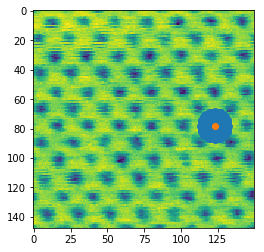

In [159]:
simpath = '/srv/home/chenyu/antisite/PRISMATIC/Depth0_OriginalPxSize/'
path = '/srv/home/chenyu/DEbackup/022119/'
name = 'S5/'
peaks_x = np.load(path + name + 'SrPeaks_x.npy')
peaks_y = np.load(path + name + 'SrPeaks_y.npy')
BF = np.load(path + name + 'BF.npy')

thickness = np.load(path + name + 'SrPeaks_thickness.npy')

BeamLevel = np.load('/srv/home/chenyu/DEbackup/022119/BeamLevel.npy')

# Select one column to do the test
iColumn = 15
radius = 10

layer = int(thickness[iColumn])
print('Column '+str(iColumn)+' has ' + str(layer)+' layers.')
x = peaks_x[iColumn]
y = peaks_y[iColumn]
print(x,y)
x = np.round(x)
y = np.round(y)
print(x,y)

# Quantitative experiment PACBED

PACBED_exp = np.zeros((512,512))
expMask = create_circular_mask(radius*2+1,radius*2+1,center=[radius,radius])
px_list = np.nonzero(expMask)
# row for non-zero pixels
row_list = px_list[0] + y - radius
col_list = px_list[1] + x - radius

# Directly visulize pixels used to generate PACBED
plt.imshow(BF[1:-1,:])
plt.scatter(col_list,row_list)
plt.scatter(x,y)

file_list= row_list*150+col_list+1

for ifile in range(file_list.size):
    frame = np.load(path + name + 'npy/S5_'+format(int(file_list[ifile]),'05')+'.npy')
    frame = frame/BeamLevel
    PACBED_exp = PACBED_exp + frame
    
PACBED_exp = PACBED_exp / file_list.size
PACBED_exp = PACBED_exp*mask/norm_mask + PACBED_exp*(1-mask) 
# PACBED_exp = PACBED_exp * 0.511 * 0.511 / 0.144 / 0.144


# Quantitative simulation PACBED
sim_cube = np.load(simpath+'depth0_slice'+str(layer+1)+'_110pmss.npy')
row_list = px_list[0] + 32 - radius
col_list = px_list[1] + 33 - radius
file_list= row_list*69+col_list+1
PACBED_sim = np.zeros((328,328))

for ifile in range(file_list.size):
    frame = sim_cube[row_list[ifile],col_list[ifile],:,:]
    PACBED_sim = PACBED_sim + frame
    
PACBED_sim = PACBED_sim / file_list.size

# PACBED_exp_full = np.load(path+name+'PACBED.npy')
# PACBED_exp_full = PACBED_exp_full/150/150/BeamLevel

### Resample both PACBEDs to a new grid

In [14]:
# resample both simulation and experiment to a new grid, ranges from -40mrad to 40mrad with 1mrad/px
center_x = 293
center_y = 246
rotation = -11

# dataset for 01/21/19
center_x = 223
center_y = 255
rotation = 6

# dataset for 02/21/19
center_x = 255.8
center_y = 259.6
rotation = -27

final_size = 100
# final_size = 200
final_size = 50

exp_pxsize = 0.145
sim_pxsize = 0.511

exp_x = np.linspace(-exp_pxsize*center_x, exp_pxsize*(511-center_x), num=512)
exp_y = np.linspace(-exp_pxsize*center_y, exp_pxsize*(511-center_y), num=512)
f_exp = scipy.interpolate.RectBivariateSpline(exp_y,exp_x,PACBED_exp)
final_x = np.linspace(-40,40,num=final_size)
final_y = np.linspace(-40,40,num=final_size)
final_xx, final_yy = np.meshgrid(final_x,final_y)
exp_recon = np.zeros((final_size,final_size))
exp_recon = f_exp.ev(final_xx,final_yy)
exp_recon = exp_recon / exp_pxsize / exp_pxsize * sim_pxsize * sim_pxsize
        
sim_x = np.linspace(-sim_pxsize*164, sim_pxsize*(327-164), num=328)
sim_y = sim_x
f_sim = scipy.interpolate.RectBivariateSpline(sim_x,sim_y,PACBED_sim)
sim_recon = np.zeros((final_size,final_size))
final_x = np.linspace(-40,40,num=final_size)
final_y = np.linspace(-40,40,num=final_size)
final_xx, final_yy = np.meshgrid(final_x,final_y)
final_xx_rotated = final_xx*math.cos(math.radians(rotation))-final_yy*math.sin(math.radians(rotation))
final_yy_rotated = final_yy*math.cos(math.radians(rotation))+final_xx*math.sin(math.radians(rotation))
sim_recon = f_sim.ev(final_xx_rotated,final_yy_rotated)

NameError: name 'PACBED_sim' is not defined

[]

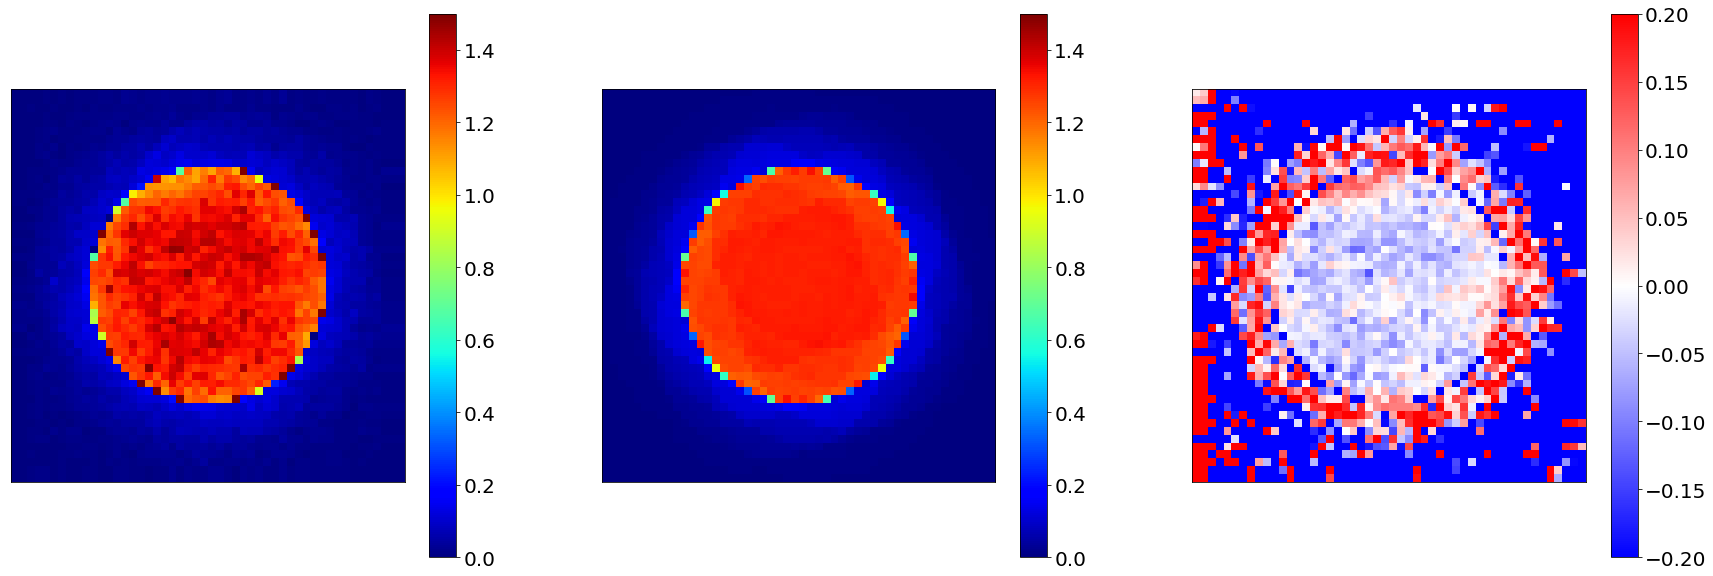

In [161]:
fig, ax = subplots(1,3,figsize=(30, 10))
im0 = ax[0].imshow(exp_recon*10000,clim=[0,1.5],cmap = plt.get_cmap('jet'))
im1 = ax[1].imshow(sim_recon*10000,clim=[0,1.5],cmap = plt.get_cmap('jet'))
# im1 = ax[1].imshow(sim_recon*10000)
cbar = fig.colorbar(im0,ax=ax[0])
cbar.ax.tick_params(labelsize=20)
cbar = fig.colorbar(im1,ax=ax[1])
cbar.ax.tick_params(labelsize=20)
im2 = ax[2].imshow((sim_recon-exp_recon)/sim_recon,clim=[-0.2,0.2],cmap=plt.get_cmap('bwr'))
cbar = fig.colorbar(im2,ax=ax[2])
cbar.ax.tick_params(labelsize=20)

ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[2].set_xticks([])
ax[2].set_yticks([])

[]

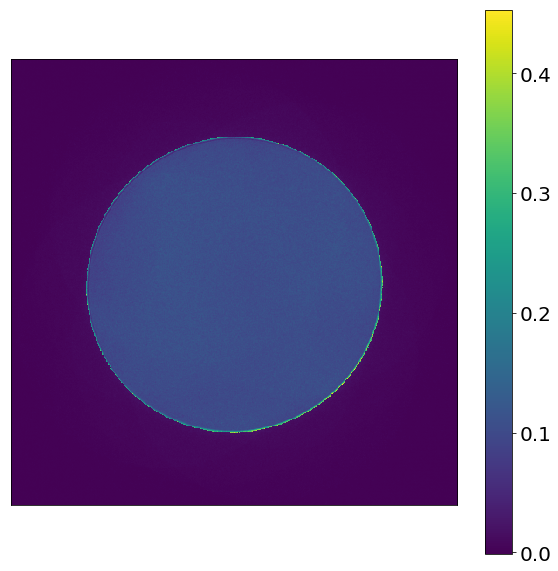

In [145]:
fig, ax = subplots(figsize=(10, 10))
im0 = ax.imshow(PACBED_exp*10000)
cbar = fig.colorbar(im0,ax=ax)
cbar.ax.tick_params(labelsize=20)
ax.set_xticks([])
ax.set_yticks([])

## auxiliary functions

In [4]:
import struct
import mrcfile
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy.io
import time

def loadMRCfile(filepath):
    with open(filepath, mode='rb') as file: # b is important -> binary
        file.seek(0)
        read_bytes = file.read(8)
        frame_width = struct.unpack('<i',read_bytes[0:4])
        frame_width = frame_width[0]
        frame_height = struct.unpack('<i',read_bytes[4:8])
        frame_height = frame_height[0]
        image = np.zeros((frame_height,frame_width))
        file.seek(256*4)
        dataset = file.read(frame_width*frame_height*4)
        for irow in range(frame_height):
            for icol in range(frame_width):
                pixel = struct.unpack('<f',dataset[(irow*frame_width+icol)*4:(irow*frame_width+icol+1)*4])[0]
                image[irow,icol] = pixel
        return image

In [5]:
def Convolution_2D(image,source_size):
    px_size = 17.5
    sigma = (source_size/px_size)/(2.355)
    kernel = gaussKernel(sigma,image.shape[1])
    fkernel = np.fft.fft2(kernel)
    #initialize result array
    result = np.zeros(image.shape,dtype=np.float32)
    #apply convolution for each pixel in (kx,ky) over the whole set of images in (x,y)
    result = np.fft.fftshift(np.fft.ifft2(fkernel*np.fft.fft2(image))).real
    
    return(result)

In [6]:
def gaussKernel(sigma,imsize):
    x,y = np.meshgrid(range(1,imsize+1),range(1,imsize+1))
    x = x - imsize//2
    y = y - imsize//2
    tmp = -(x**2+y**2)/(2*sigma**2)
    return (1/(2*np.pi*sigma**2))*np.exp(tmp)

In [7]:
def create_circular_mask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = [int(w/2), int(h/2)]
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

In [8]:
def BeamLevelCalibrate(path,size):
    center = [258,261]
    mask = create_circular_mask(size,size, center, 5)
    with open(path) as csvfile:
        file=csv.reader(open(path,'r'))
        Beam = []
        Dark = []
        n=[]
        for row in file:
            n.append(row)
            
    HAADFarray = np.transpose(np.asarray(n))
    HAADFarray = np.squeeze(HAADFarray)
    HAADFarray = HAADFarray.astype(np.float)
    DetectorScan = np.reshape(HAADFarray,(size,size))
    
    DarkLevel = DetectorScan[np.nonzero(DetectorScan*mask)].mean()
    DarkLevel = np.amin(DetectorScan)
    BeamLevel = DetectorScan[np.nonzero(np.heaviside(DetectorScan,0))].mean()

    return(BeamLevel,DarkLevel)

In [9]:
def gaussianx2(xdata_tuple,bg,height, center_x, center_y, width_x, width_y):

    (x, y) = xdata_tuple
    width_x = float(width_x)
    width_y = float(width_y)
    g = height*exp(
                 -(((center_x-x)/width_x)**2+((center_y-y)/width_y)**2)/2)+bg
    return g.ravel()

In [10]:
def fitGaussianx2(data, guess, bounds):
    x = np.linspace(0, data.shape[1]-1, data.shape[1])
    y = np.linspace(0, data.shape[0]-1, data.shape[0])
    x, y = np.meshgrid(x, y)
    xdata_tuple = (x,y)
    popt, pcov = optimize.curve_fit(gaussianx2, xdata_tuple, data.ravel(), p0=guess,bounds=bounds,method='trf',verbose=0,maxfev=100000)
    return popt

In [9]:
import struct
import mrcfile
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy.io
import time

def loadMRCfile_3D(filepath):
    with open(filepath, mode='rb') as file: # b is important -> binary
        file.seek(0)
        read_bytes = file.read(12)
        frame_width = struct.unpack('<i',read_bytes[0:4])
        frame_width = frame_width[0]
        frame_height = struct.unpack('<i',read_bytes[4:8])
        frame_height = frame_height[0]
        frame_layer = struct.unpack('<i',read_bytes[8:12])
        frame_layer = frame_layer[0]
        # frame_layer should be the slowest changing dimensiion in the data, thus the first layer in the reading loop
        image = np.zeros((frame_height,frame_width,frame_layer))

        file.seek(256*4)
        dataset = file.read(frame_width*frame_height*frame_layer*4)
        
        for ilayer in range(frame_layer):
            for irow in range(frame_height):
                for icol in range(frame_width):
                    pixel = struct.unpack('<f',dataset[(ilayer*frame_width*frame_height+irow*frame_width+icol)*4:(ilayer*frame_width*frame_height+irow*frame_width+icol+1)*4])[0]
                    image[irow,icol,ilayer] = pixel
        return image

In [10]:
from scipy.interpolate import griddata
from numpy import exp, abs,angle
from scipy.interpolate import RectBivariateSpline

def convert (img, size, center, correction=False, plot=False):
    '''
    :param img: a 2-d array for the image to convert to polar coordinates
    :param center: x,y coordinates for the center of the image
    :param correction: the circular correction
    :param size: [x,y] describing the pixel dimensions of the photo
    :return: polar_img r vs. theta
    '''
    phase_width = 360
    r_inital = 0
    r_final =280
    final_theta, final_r = create_grid(np.linspace(-1*np.pi,np.pi,phase_width),np.arange(0,r_final,1))
#     initial_x, initial_y = create_grid(range(1,size[0]+1),range(1,size[1]+1))
#     initial_y, initial_x = range(1, 513), range(1, 513)
    initial_y, initial_x = range(1, size[0]+1), range(1, size[1]+1)
    final_x, final_y = polar_list_to_cartesian(final_r,final_theta,center)
    
    #initial_theta, initial_r = cartesian_list_to_polar(initial_x,initial_y,center)
#     inten = np.reshape(img,size[0]*size[1])
#     polar_img = griddata((initial_x,initial_y),inten,(final_x,final_y), method='linear')
    inten = img
    spline = RectBivariateSpline(initial_x, initial_y,inten,kx=1,ky=1)
    polar_img = spline.ev(final_x,final_y)
    
    polar_img = np.reshape(polar_img, [r_final, phase_width])
    if plot:
        plt.imshow(polar_img, extent=(0, 6.293, 0, 6))
        plt.show()
    return polar_img

def cartesian_to_polar(x,y,center):
    '''
    A function that converts the x,y coordinates to polar ones.
    -Does not do the circular correction
    '''
    corrected_x= x-center[0]
    corrected_y= y-center[1]
    theta = np.arctan2(corrected_y,corrected_x)
    r = np.sqrt(corrected_x**2+ corrected_y**2)
    return theta,r

def polar_to_cartesian(r, theta, center):
    x = center[0]+r*np.cos(theta)
    y = center[1] +r*np.sin(theta)
    return x,y

def cartesian_list_to_polar(x_list,y_list,center):
    theta_list = []
    r_list = []
    for x,y in zip(x_list,y_list):
        t,r =cartesian_to_polar(x,y,center)
        theta_list.append(t)
        r_list.append(r)
    return theta_list, r_list

def polar_list_to_cartesian(r_list,theta_list, center):
    x_list = []
    y_list = []
    for r, t in zip(r_list,theta_list):
        x,y = polar_to_cartesian(r,t,center)
        x_list.append(x)
        y_list.append(y)
    return x_list,y_list

def create_grid (dimension1,dimension2):
    '''
    Takes data from array of points turns it into a grid of coordinates
    '''
    dim1,dim2 =np.meshgrid(dimension1,dimension2)
    size = len(dimension1)*len(dimension2)
    a,b = np.reshape(dim1,size),np.reshape(dim2,size)
    return a,b

def circular_grid_data(intial_r, initial_theta, intensity, final_r,final_theta):
    #interpolating the radi and theta values from the cartesian points and mapping the intesities to evenly spaced
    # points in r an theta through linear interpolation... possibly some other interpolation....
    #for r,t in zip(final_r,final_theta):

    return


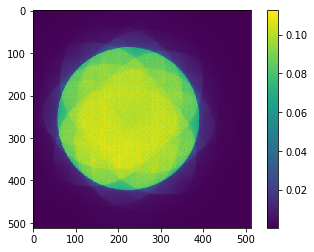

In [17]:
temp = np.load('/srv/home/chenyu/DEbackup/012119/S3/PACBED.npy')
BeamLevel = 17712866.300978005
plt.imshow(temp/150/150/BeamLevel*10000)
cbar = plt.colorbar()

[]

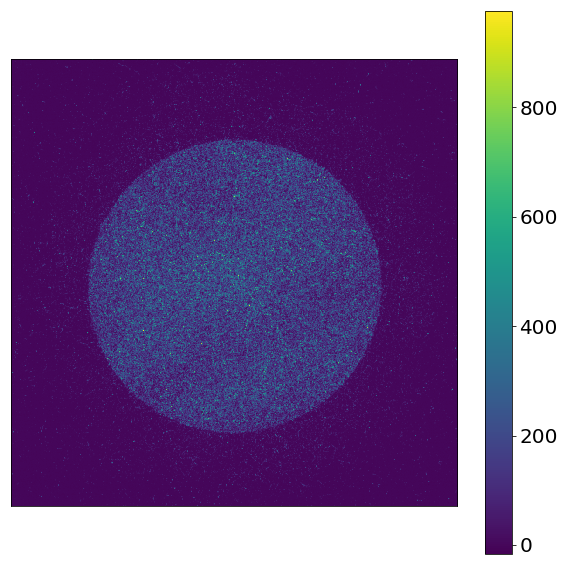

In [19]:
temp = np.load('/srv/home/chenyu/DEbackup/022119/S5/npy/S5_10000.npy')

fig, ax = subplots(figsize=(10, 10))
im0 = ax.imshow(temp)
cbar = fig.colorbar(im0,ax=ax)
cbar.ax.tick_params(labelsize=20)
ax.set_xticks([])
ax.set_yticks([])

[]

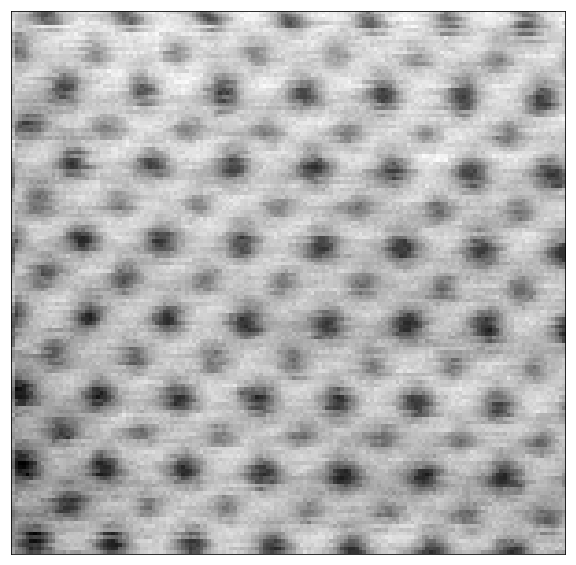

In [47]:
temp = np.load('/srv/home/chenyu/DEbackup/021019/S2/BF.npy')

fig, ax = subplots(figsize=(10, 10))
# im0 = ax.imshow(np.sqrt(temp[2:-1,:,1]*temp[2:-1,:,1]+temp[2:-1,:,0]*temp[2:-1,:,0]))
im0 = ax.imshow(temp[2:-1,:],cmap='gray')

# cbar = fig.colorbar(im0,ax=ax)
# cbar.ax.tick_params(labelsize=20)
ax.set_xticks([])
ax.set_yticks([])


# fig, ax = subplots(figsize=(10, 10))
# im = ax.imshow(np.sqrt(temp[2:-1,:,1]*temp[2:-1,:,1]+temp[2:-1,:,0]*temp[2:-1,:,0]))
# cbar = fig.colorbar(im,ax=ax)

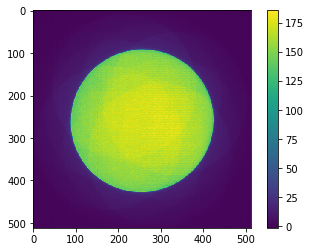

In [532]:
simpath = '/srv/home/chenyu/antisite/PRISMATIC/Depth0_OriginalPxSize/'
BeamLevel = np.load('/srv/home/chenyu/DEbackup/022119/BeamLevel.npy')
PACBED_exp = np.load('/srv/home/chenyu/DEbackup/022119/S5/PACBED.npy')
PACBED_exp = PACBED_exp / 150 / 150
plt.imshow(PACBED_exp)
plt.colorbar()

In [162]:
final_xx = 13.7
final_yy = -13.6
rotation = -27
final_xx_rotated = final_xx*math.cos(math.radians(rotation))-final_yy*math.sin(math.radians(rotation))
final_yy_rotated = final_yy*math.cos(math.radians(rotation))+final_xx*math.sin(math.radians(rotation))
print(final_xx_rotated,final_yy_rotated)

6.032518584922804 -18.337358575393594
